<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Lorenz-trajectory" data-toc-modified-id="Lorenz-trajectory-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Lorenz trajectory</a></span><ul class="toc-item"><li><span><a href="#CV-predictions" data-toc-modified-id="CV-predictions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>CV predictions</a></span></li><li><span><a href="#Check-gpu" data-toc-modified-id="Check-gpu-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Check gpu</a></span><ul class="toc-item"><li><span><a href="#Cluster" data-toc-modified-id="Cluster-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Cluster</a></span></li><li><span><a href="#Quantile" data-toc-modified-id="Quantile-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Quantile</a></span></li><li><span><a href="#heal" data-toc-modified-id="heal-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>heal</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from tqdm.auto import tqdm

In [2]:
from src.Lorentz import Lorentz
from src.TSProcessor_GPU import TSProcessor

%load_ext autoreload
%autoreload 2

In [3]:
from src.utils import normalize, denormalize, gen_sin_wave, plot_trajectories, plot_runs
from copy import deepcopy
import cupy as cp

In [4]:
import torch
import gc

## Lorenz trajectory

### CV predictions

In [21]:
train_size = 1900
h_max = 100 # max prediction horizon (t+h)
n_folds = 500


points_in_template = 4
max_template_spread = 10 # max distance between y_t1 and y_t2, y_1 and y_11


# trajectories prediction parameters
eps = 0.01
n_trajectories = 24
noise_amp = 0.01
priori_eps = 0.2


# unified prediction parameters
dbs_eps = 0.01
dbs_min_samples = int(0.25*n_trajectories)
dbs_min_trajectories = int(0.25*n_trajectories)
# dbs_cluster_difference = int(0.25*n_trajectories)

alpha = 0.2
max_err = 0.05
min_trajectories = int(0.5*n_trajectories)

assert n_trajectories*(1-2*alpha) > min_trajectories

In [6]:
x, _, _ = Lorentz().generate(0.1, 3000+n_folds*(train_size+h_max)-1) # -1 because of an implementation bug
x, x_min, x_max = normalize(x[3000:]) # "For the Lorenz series, the first 3000 observations are discarded..."

In [8]:
runs = {
    'single': {
        'rmse': np.zeros((n_folds, h_max)),
        'non_pred': np.zeros((n_folds, h_max)),
    },
    'priori': {
        'rmse': np.zeros((n_folds, h_max)),
        'non_pred': np.zeros((n_folds, h_max)),
    },
    'unified': {
        'rmse': np.zeros((n_folds, h_max)),
        'non_pred': np.zeros((n_folds, h_max)),
    },
    'unified_quantile': {
        'rmse': np.zeros((n_folds, h_max)),
        'non_pred': np.zeros((n_folds, h_max)),
    },
    'unified_healing': {
        'rmse': np.zeros((n_folds, h_max)),
        'non_pred': np.zeros((n_folds, h_max)),
    },
}

In [10]:
# priori and single
for fold in tqdm(range(n_folds)):
    t = (train_size+h_max) * fold
    X_train = x[t:t+train_size].copy()
    X_train = torch.from_numpy(X_train).type(torch.float32).to('cuda')
    
    start_points = max_template_spread * (points_in_template-1)
    
    X_start = x[t+train_size-start_points:t+train_size].copy()
    X_start = torch.from_numpy(X_start).type(torch.float32).to('cuda')
    
    X_test_cpu = x[t+train_size:t+train_size+h_max].copy()
    X_test = torch.from_numpy(X_test_cpu).type(torch.float32).to('cuda')
    
    
    tsp = TSProcessor(
        points_in_template=points_in_template,
        max_template_spread=max_template_spread,
        X_train=X_train,
    )
    

    # priori
    X_traj_pred = tsp.predict_trajectories(
        X_start, h_max,
        eps=eps,
        n_trajectories=n_trajectories,
        noise_amp=noise_amp,
        use_priori=True,
        X_test=X_test,
        priori_eps=priori_eps,
    )
    X_traj_pred = X_traj_pred.cpu().numpy()
    
    unified_result = tsp.predict_unified(
        X_traj_pred,
        method='cluster',
        use_priori=True,
        X_test=X_test_cpu,
        priori_eps=priori_eps,
        dbs_min_trajectories=dbs_min_trajectories,
        dbs_eps=dbs_eps,
        dbs_min_samples=dbs_min_samples,
    )
    X_pred = unified_result['X_pred']
    
    non_pred = np.isnan(X_pred).astype(int)
    rmse = (X_pred - X_test_cpu)**2
    runs['priori']['rmse'][fold] = rmse
    runs['priori']['non_pred'][fold] = non_pred
    
    gc.collect()
    torch.cuda.empty_cache()
    
    
    # single
    X_traj_pred = tsp.predict_trajectories(
        X_start, h_max,
        eps=eps,
        n_trajectories=1,
        noise_amp=0,
        use_priori=False,
    )
    X_traj_pred = X_traj_pred.cpu().numpy()
    X_pred = X_traj_pred[:, 0]
    
    non_pred = np.isnan(X_pred).astype(int)
    rmse = (X_pred - X_test_cpu)**2
    runs['single']['rmse'][fold] = rmse
    runs['single']['non_pred'][fold] = non_pred
    
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/500 [00:00<?, ?it/s]

In [11]:
# unified and unified_quantile
for fold in tqdm(range(n_folds)):
    t = (train_size+h_max) * fold
    X_train = x[t:t+train_size]
    X_train = torch.from_numpy(X_train).type(torch.float32).to('cuda')
    
    start_points = max_template_spread * (points_in_template-1)
    
    X_start = x[t+train_size-start_points:t+train_size]
    X_start = torch.from_numpy(X_start).type(torch.float32).to('cuda')
    
    X_test_cpu = x[t+train_size:t+train_size+h_max]
    X_test = torch.from_numpy(X_test_cpu).type(torch.float32).to('cuda')
    
    
    tsp = TSProcessor(
        points_in_template=points_in_template,
        max_template_spread=max_template_spread,
        X_train=X_train,
    )
    
    # unified
    X_traj_pred = tsp.predict_trajectories(
        X_start, h_max,
        eps=eps,
        n_trajectories=n_trajectories,
        noise_amp=noise_amp,
    )
    X_traj_pred = X_traj_pred.cpu().numpy()
    
    unified_result = tsp.predict_unified(
        X_traj_pred,
        method='cluster',
        dbs_min_trajectories=dbs_min_trajectories,
        dbs_eps=dbs_eps,
        dbs_min_samples=dbs_min_samples,
    )
    X_pred = unified_result['X_pred']
    
    non_pred = np.isnan(X_pred).astype(int)
    rmse = (X_pred - X_test_cpu)**2
    runs['unified']['rmse'][fold] = rmse
    runs['unified']['non_pred'][fold] = non_pred
    
    gc.collect()
    torch.cuda.empty_cache()
    
    
    # unified_quantile
    
    # reusing X_traj_pred from previoius step
    unified_result = tsp.predict_unified(
        X_traj_pred,
        method='quantile',
        alpha=alpha,
        max_err=max_err,
        min_trajectories=min_trajectories,
    )
    X_pred = unified_result['X_pred']
    
    non_pred = np.isnan(X_pred).astype(int)
    rmse = (X_pred - X_test_cpu)**2
    runs['unified_quantile']['rmse'][fold] = rmse
    runs['unified_quantile']['non_pred'][fold] = non_pred
    
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/500 [00:00<?, ?it/s]

In [12]:
# healing
for fold in tqdm(range(n_folds)):
    t = (train_size+h_max) * fold
    X_train = x[t:t+train_size]
    X_train = torch.from_numpy(X_train).type(torch.float32).to('cuda')
    
    start_points = max_template_spread * (points_in_template-1)
    
    X_start = x[t+train_size-start_points:t+train_size]
    X_start = torch.from_numpy(X_start).type(torch.float32).to('cuda')
    
    X_test_cpu = x[t+train_size:t+train_size+h_max]
    X_test = torch.from_numpy(X_test_cpu).type(torch.float32).to('cuda')
    
    
    tsp = TSProcessor(
        points_in_template=points_in_template,
        max_template_spread=max_template_spread,
        X_train=X_train,
    )
    
    # healing
    X_traj_pred = tsp.predict_trajectories(
        X_start, h_max,
        eps=eps,
        n_trajectories=n_trajectories,
        noise_amp=noise_amp,
    )
    X_traj_pred = X_traj_pred.cpu().numpy()
    unified_result = tsp.predict_unified(
        X_traj_pred,
        method='cluster',
        dbs_min_trajectories=dbs_min_trajectories,
        dbs_eps=dbs_eps,
        dbs_min_samples=dbs_min_samples,
    )
    X_pred = unified_result['X_pred']
    
    gc.collect()
    torch.cuda.empty_cache()
    
    X_traj_pred = tsp.predict_trajectories(
        X_start, h_max,
        eps=eps,
        n_trajectories=n_trajectories,
        noise_amp=noise_amp,
        X_pred=X_pred,
    )
    X_traj_pred = X_traj_pred.cpu().numpy()
    unified_result = tsp.predict_unified(
        X_traj_pred,
        method='cluster',
        dbs_min_trajectories=dbs_min_trajectories,
        dbs_eps=dbs_eps,
        dbs_min_samples=dbs_min_samples,
    )
    X_pred = unified_result['X_pred']
    
    gc.collect()
    torch.cuda.empty_cache()
    
    X_traj_pred = tsp.predict_trajectories(
        X_start, h_max,
        eps=eps,
        n_trajectories=n_trajectories,
        noise_amp=noise_amp,
        X_pred=X_pred,
    )
    X_traj_pred = X_traj_pred.cpu().numpy()
    unified_result = tsp.predict_unified(
        X_traj_pred,
        method='cluster',
        dbs_min_trajectories=dbs_min_trajectories,
        dbs_eps=dbs_eps,
        dbs_min_samples=dbs_min_samples,
    )
    X_pred = unified_result['X_pred']
    
    gc.collect()
    torch.cuda.empty_cache()
    
    non_pred = np.isnan(X_pred).astype(int)
    rmse = (X_pred - X_test_cpu)**2
    runs['unified_healing']['rmse'][fold] = rmse
    runs['unified_healing']['non_pred'][fold] = non_pred
    
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/500 [00:00<?, ?it/s]

In [19]:
# import pickle
# pickle.dump(runs, open( "runs.p", "wb" ) )

In [20]:
runs_processed = deepcopy(runs)
for method in runs_processed.keys():
    rmses = runs_processed[method]['rmse']
    non_preds = runs_processed[method]['non_pred']
    non_preds = 100*non_preds.sum(axis=0) / non_preds.shape[0]
    # might be bogged
    # np.sqrt(np.nan_to_num(rmses / (rmses.shape[0] - np.isnan(rmses).sum(axis=0))).sum(axis=0))
    rmses = np.sqrt(np.nanmean(rmses, axis=0))
    runs_processed[method]['rmse'] = rmses
    runs_processed[method]['non_pred'] = non_preds

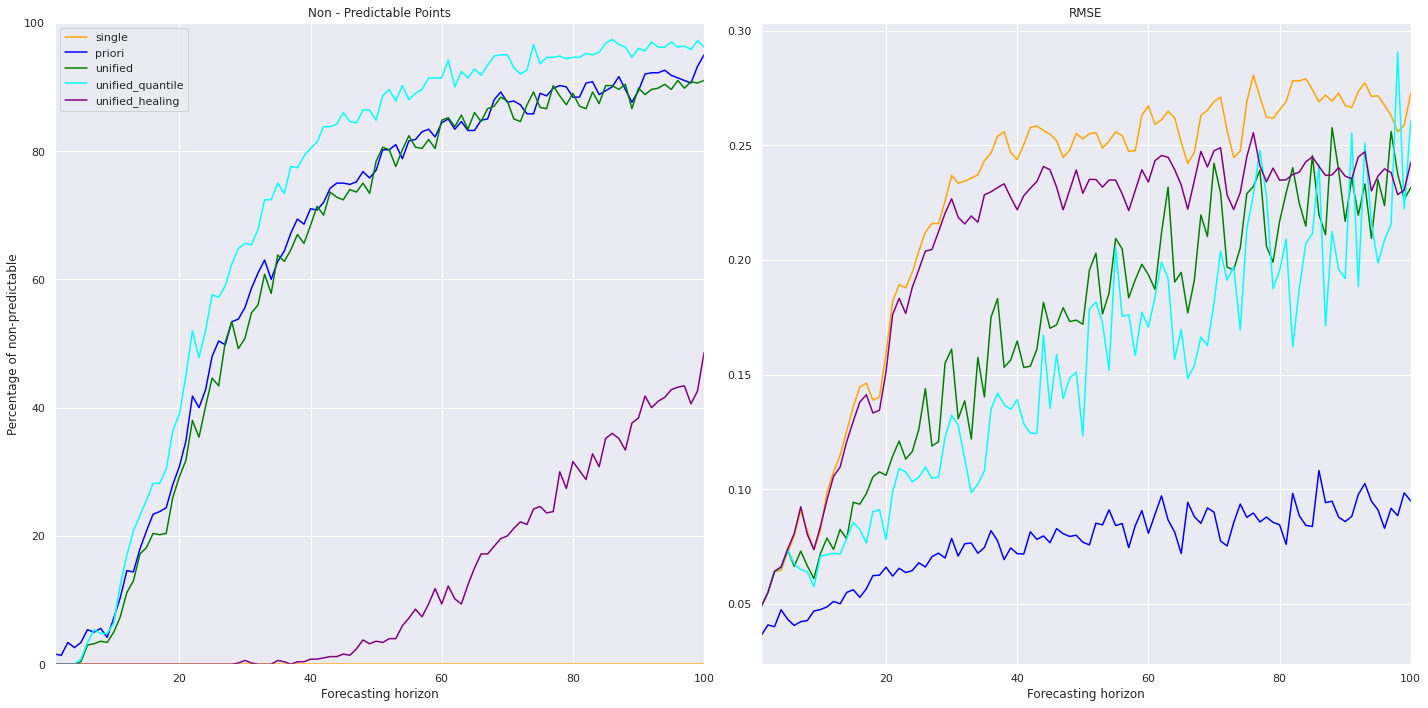

In [21]:
plot_runs(runs_processed, h_max, filename=f'images/fig4_healing_gpu_{h_max}_{noise_amp:.3f}.png')

In [22]:
tmp = []
for method in runs.keys():
    rmse = runs[method]['rmse']
    rmses = np.sqrt(np.nanmean(rmse, axis=0))
    tmp += [(method, i+1, rmses[i]) for i in range(len(rmses))]

runs_df = pd.DataFrame(tmp, columns=['method', 'step', 'rmse'])

In [23]:
# runs_df.to_csv('runs_gpu.csv')

In [24]:
diff = (runs_df[runs_df['method'] == 'unified_healing']['rmse'].to_numpy() -
 runs_df[runs_df['method'] == 'unified']['rmse'].to_numpy())

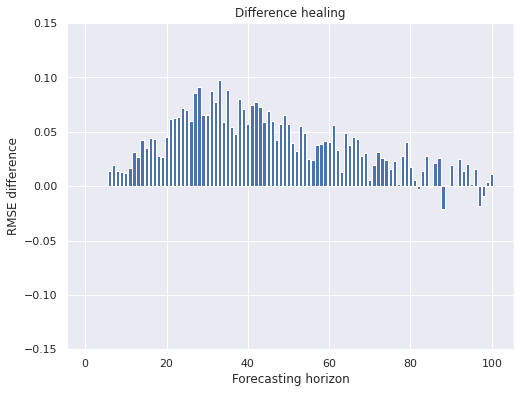

In [25]:
fig = plt.figure(figsize=(8, 6))

plt.title('Difference healing')
plt.bar(range(1, len(diff)+1), diff)
plt.xlabel('Forecasting horizon');
plt.ylabel('RMSE difference');
plt.ylim(-0.15, 0.15)

fig.savefig('images/healing_improvement_gpu.png')

### Check gpu

#### Cluster

In [93]:
train_size = 1900
h_max = 100 # max prediction horizon (t+h)
n_folds = 500


points_in_template = 4
max_template_spread = 10 # max distance between y_t1 and y_t2, y_1 and y_11


# trajectories prediction parameters
eps = 0.01
n_trajectories = 24
noise_amp = 0.01
priori_eps = 0.2


# unified prediction parameters
dbs_eps = 0.01
dbs_min_samples = int(0.25*n_trajectories)
dbs_min_trajectories = int(0.25*n_trajectories)
# dbs_cluster_difference = int(0.25*n_trajectories)

alpha = 0.2
max_err = 0.05
min_trajectories = int(0.5*n_trajectories)

assert n_trajectories*(1-2*alpha) > min_trajectories

In [94]:
fold = 0
t = (train_size+h_max) * fold

X_train = x[t:t+train_size]
X_train = torch.from_numpy(X_train).type(torch.float32).to('cuda')

start_points = max_template_spread * (points_in_template-1)

X_start = x[t+train_size-start_points:t+train_size]
X_start = torch.from_numpy(X_start).type(torch.float32).to('cuda')

X_test_cpu = x[t+train_size:t+train_size+h_max]
X_test = torch.from_numpy(X_test_cpu).type(torch.float32).to('cuda')


tsp = TSProcessor(
    points_in_template=points_in_template,
    max_template_spread=max_template_spread,
    X_train=X_train,
)

In [95]:
X_traj_pred = tsp.predict_trajectories(
    X_start, h_max,
    eps=eps,
    n_trajectories=n_trajectories,
    noise_amp=noise_amp,
    use_priori=False,
    X_test=X_test,
    priori_eps=priori_eps,
    random_seed=1
)

In [96]:
X_traj_pred = X_traj_pred.cpu().numpy()

In [97]:
unified_result = tsp.predict_unified(
    X_traj_pred,
    method='cluster',
    dbs_min_trajectories=dbs_min_trajectories,
    dbs_eps=dbs_eps,
    dbs_min_samples=dbs_min_samples,
)
X_pred = unified_result['X_pred']

non_pred = np.isnan(X_pred).astype(int)
rmse = (X_pred - X_test_cpu)**2

gc.collect()
torch.cuda.empty_cache()

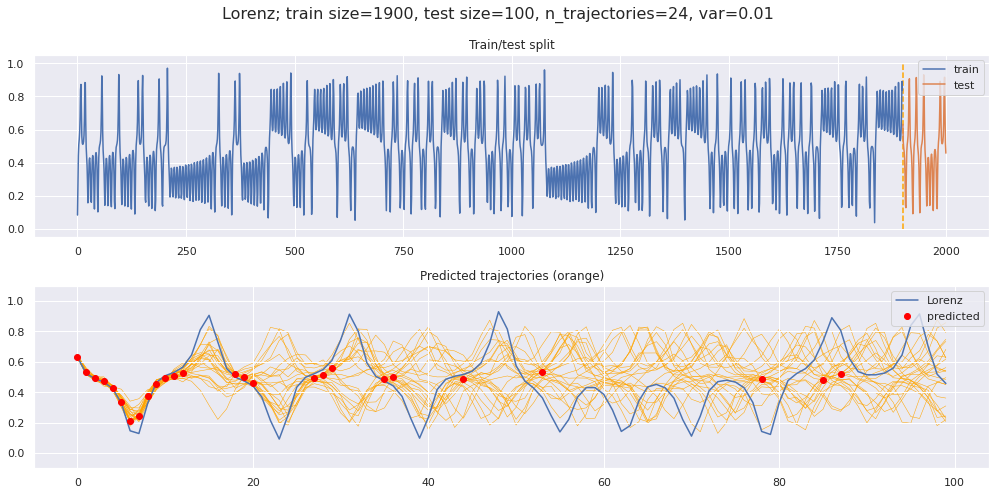

In [98]:
plot_trajectories(
    'Lorenz', X_train.cpu().numpy(), X_test.cpu().numpy(), # plotting since X_start
    noise_amp, n_trajectories,
    X_traj_pred, X_pred, non_pred, rmse#, filename=f'Lorenz_cluster_{fold}_{noise_amp:.2f}.png'
)

#### Quantile

In [100]:
unified_result = tsp.predict_unified(
    X_traj_pred,
    method='quantile',
    use_priori=False,
    min_trajectories=min_trajectories,
    max_err=max_err,
    alpha=alpha,
)
X_pred = unified_result['X_pred']
qs = unified_result['qs']
traj_alive = unified_result['traj_alive']

non_pred = np.isnan(X_pred).astype(int)
rmse = (X_pred - X_test_cpu)**2

gc.collect()
torch.cuda.empty_cache()

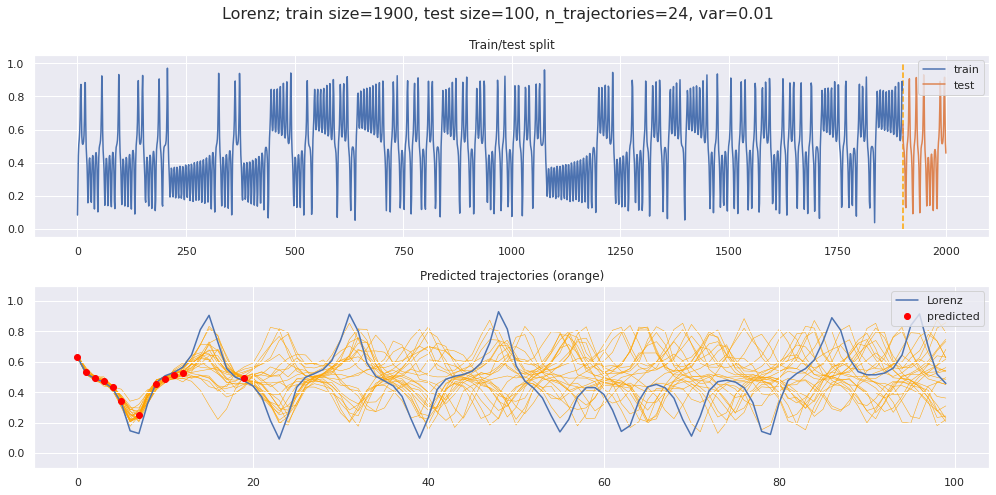

In [101]:
plot_trajectories(
    'Lorenz', X_train.cpu().numpy(), X_test.cpu().numpy(), # plotting since X_start
    noise_amp, n_trajectories,
    X_traj_pred, X_pred, non_pred, rmse, filename=f'Lorenz_cluster_{fold}_{noise_amp:.2f}.png'
)

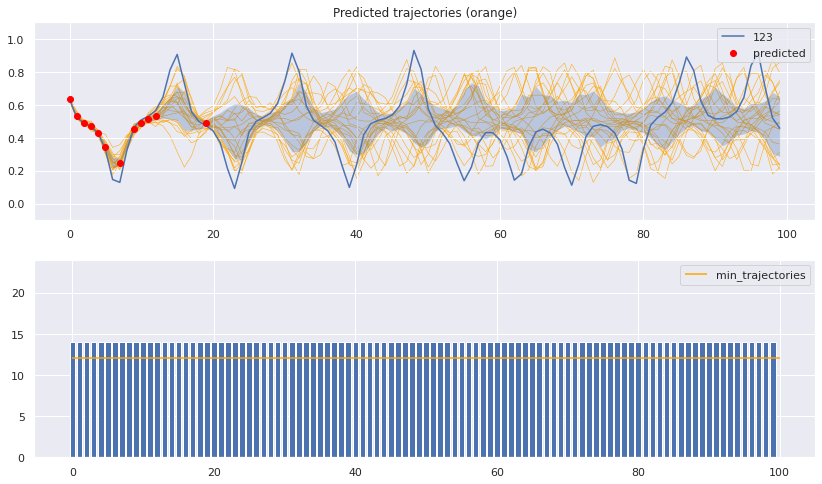

In [102]:
# quantile plot

fig = plt.figure(figsize=[14, 8])

plt.subplot(2, 1, 1)
plt.plot(X_test_cpu, label='123', zorder=1)

plt.ylim(-0.1, 1.1)

for i in range(n_trajectories):
    plt.plot(X_traj_pred[:, i], c='orange', lw=0.5, zorder=0)

plt.scatter(range(X_pred.size),
            X_pred,
            label='predicted',
            c='red',
            zorder=2)

plt.fill_between(range(len(qs)), qs[:, 0], qs[:, 1], alpha=0.3)

plt.title('Predicted trajectories (orange)')
plt.legend(loc='upper right');

plt.subplot(2, 1, 2)
plt.bar(range(len(traj_alive)), traj_alive)
plt.hlines(y=min_trajectories, xmin=0, xmax=len(traj_alive),
           color='orange', label='min_trajectories')
plt.legend()
plt.ylim(0, n_trajectories);

#### heal